In [1]:
import influxdb_client, os, time
from influxdb_client import InfluxDBClient, Point, WritePrecision
from queryDSL import InfluxQueryBuilder, QueryAggregation, QueryFilter
import requests
import json


In [12]:
token = "NVRAh0Hy9gLvSJVlIaYVRIP5MTktlqBHCOGxpgzIOHdSD-fu2vGjug5NmMcTv2QvH7BK6XG0tQvaoPXUWmuvLQ=="
org = "Realtime"
url = "http://localhost:8086"
cacheUrlRaw = "http://127.0.0.1:5000/api/queryRaw"
cacheUrlJson = "http://127.0.0.1:5000/api/query"
resetUrl = "http://127.0.0.1:5000/api/reset"
client = influxdb_client.InfluxDBClient(url=url, token=token, org=org)

query_api = client.query_api()

In [3]:
query3Builder = (InfluxQueryBuilder()
             .withBucket("Test")
             .withFilter(QueryFilter("_measurement", "cpu_usage"))
             .withFilter(QueryFilter("_field", "value"))
             .withFilter(QueryFilter("platform", "mac_os").OR(QueryFilter("platform", "windows")))
             .withAggregate(QueryAggregation("1m", "median", False))
             .withRelativeRange('10m', None)
             .withYield("median")
    )

query4Builder = (InfluxQueryBuilder()
              .withBucket("Test")
              .withFilter(QueryFilter("_measurement", "cpu_usage"))
              .withFilter(QueryFilter("_field", "value"))
              .withFilter(QueryFilter("platform", "mac_os").OR(QueryFilter("platform", "windows")))
              .withAggregate(QueryAggregation("1m", "mean", False))
              .withRelativeRange('180m', None)
              .withYield("median")
      )

query3 = query3Builder.build()
query4 = query4Builder.build()
query3Json = query3Builder.buildJson()
query4Json = query4Builder.buildJson()

In [56]:
# Test runtime speed of queries against Cache for partial cache hits

runs = 10
delay = 1
without = []
cached = []
for i in range(runs):
   #query2
   start = time.time()
   query4Str = InfluxQueryBuilder.fromJson(query4Json).build()
   tables2 = query_api.query(query4Str, org="Realtime").to_json()
   elapsed = time.time() - start
   without.append(elapsed)
   #cachedJson
   query4Json = query4Builder.buildJson()
   start = time.time()
   result = requests.post(cacheUrlJson, json=query4Json).text
   elapsed = time.time() - start
   cached.append(elapsed)
   time.sleep(delay)

In [57]:
#Performance results
print("Without cache: avg", sum(without)/len(without), "seconds")
print("With cache: avg", sum(cached)/len(cached), "seconds")

Without cache: avg 0.04470057487487793 seconds
With cache: avg 0.02695608139038086 seconds


In [14]:
#Correctness test
query5Builder = (InfluxQueryBuilder()
              .withBucket("Test")
              .withFilter(QueryFilter("_measurement", "cpu_usage"))
              .withFilter(QueryFilter("_field", "value"))
              .withFilter(QueryFilter("platform", "mac_os").OR(QueryFilter("platform", "windows")))
              .withAggregate(QueryAggregation("1m", "mean", False))
              .withRelativeRange('75m', '15m')
              .withYield("median")
      )

query6Builder = (InfluxQueryBuilder()
              .withBucket("Test")
              .withFilter(QueryFilter("_measurement", "cpu_usage"))
              .withFilter(QueryFilter("_field", "value"))
              .withFilter(QueryFilter("platform", "mac_os").OR(QueryFilter("platform", "windows")))
              .withAggregate(QueryAggregation("1m", "mean", False))
              .withRelativeRange('65m', '5m')
              .withYield("median")
      )

query5Json = query5Builder.buildJson()
query6Json = query6Builder.buildJson()
query5Str = query5Builder.build()
query6Str = query6Builder.build()

In [53]:
reset = requests.post(resetUrl)
influxDBResult = json.loads(query_api.query(query6Str, org="Realtime").to_json())
cacheStore = requests.post(cacheUrlJson, json=query5Json)
time.sleep(2)
cacheResult = requests.post(cacheUrlJson, json=query6Json).json()

print(query6Json)
print(query6Str)
print(len(influxDBResult))
print(len(cacheResult))

{'bucket': 'Test', 'range': {'start': 1710148085, 'end': 1710151685}, 'filters': [{'key': '_measurement', 'value': 'cpu_usage', 'type': 'raw'}, {'key': '_field', 'value': 'value', 'type': 'raw'}, {'filter': [{'key': 'platform', 'value': 'mac_os', 'type': 'raw'}, {'key': 'platform', 'value': 'windows', 'type': 'raw'}], 'type': 'or'}], 'yield': 'median', 'aggregate': {'timeWindow': '1m', 'aggFunc': 'mean', 'createEmpty': False}}
from(bucket: "Test")
|> range(start: 1710148085, stop: 1710151685)
|> filter(fn: (r) => r["_measurement"] == "cpu_usage")
|> filter(fn: (r) => r["_field"] == "value")
|> filter(fn: (r) => r["platform"] == "mac_os" or r["platform"] == "windows")
|> aggregateWindow(every: 1m, fn: mean, createEmpty: false)
|> yield(name: "median")
104
106


In [54]:
from matplotlib import pyplot as plt
import numpy as np

def extractPlots(json):
    result = dict()
    curTable = 0
    for item in json:
        platform = item["platform"]
        value = item["_value"]
        time = item["_time"]
        if platform not in result:
            result[platform] = dict()
            result[platform]["time"] = []
            result[platform]["value"] = []
        result[platform]["time"].append(time)
        result[platform]["value"].append(value)
    return result

influxArrs = extractPlots(influxDBResult)
cacheArrs = extractPlots(cacheResult)

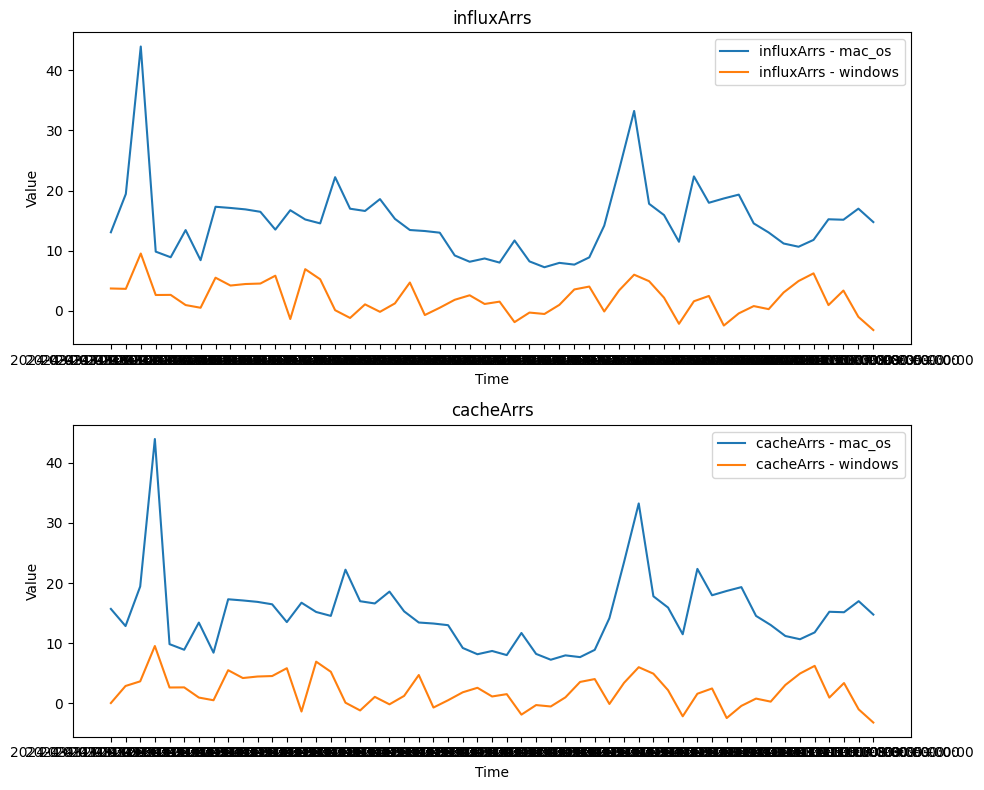

In [55]:
import matplotlib.pyplot as plt

# Plotting cacheArrs
import matplotlib.pyplot as plt

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plotting influxArrs
for platform, data in influxArrs.items():
    ax1.plot(data['time'], data['value'], label=f'influxArrs - {platform}')

# Set title and labels for influxArrs subplot
ax1.set_title('influxArrs')
ax1.set_xlabel('Time')
ax1.set_ylabel('Value')
ax1.legend()

# Plotting cacheArrs
for platform, data in cacheArrs.items():
    ax2.plot(data['time'], data['value'], label=f'cacheArrs - {platform}')

# Set title and labels for cacheArrs subplot
ax2.set_title('cacheArrs')
ax2.set_xlabel('Time')
ax2.set_ylabel('Value')
ax2.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()



